### Deforestation Detection Using Sentinel-1 SAR

GEOG 313: Advanced Geospatial w/ Python Final Project

This project is in collaboration with my internship with Trillion Trees. The goal of this project is to identify areas that have been deforested in the past 10 years using sentinel-1 SAR imagrey.
By inputting an AOI, the current iteration of this code 

In [1]:
import utils
import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
print(client.dashboard_link)

http://127.0.0.1:8787/status


2024-12-18 21:43:58,469 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('getitem-090284d5b2037716f7433783ef4b4b4d', 15, 0, 1) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7fa6e1d8d6c0>, (('astype-074e9ab9c0c4415e30b0e4aec78b5321', 16, 0, 1),), {})
new run_spec: (<function execute_task at 0x7fa6e1d8d6c0>, (('astype-getitem-090284d5b2037716f7433783ef4b4b4d', 15, 0, 1),), {})
old token: ('tuple', (('913ceb5b5beb463a9010ec0790bc30002ca34164', []), ('tuple', (('tuple', ('astype-074e9ab9c0c4415e30b0e4aec78b5321', 16, 0, 1)),)), ('dict', ())))
new token: ('tuple', (('913ce

In [2]:
start = "2015-01-01"
end = "2024-12-31"
aoi = (38.73735040426255, -5.047439253672179, 38.73931780457497, -5.046370529620204)

I chose an area where I knew deforestation occured in 2019 (according to google earth historical imagery) as an example. Users can also choose a different place within Tanzania by zooming to that area.

In [20]:
import leafmap
m = leafmap.Map(center=[-5.0467299, 38.7375924], zoom=18, height="800px")
m.add_basemap("SATELLITE")
m.add_marker([aoi[1], aoi[0]])
m.add_marker([aoi[1], aoi[2]])
m.add_marker([aoi[3], aoi[0]])
m.add_marker([aoi[3], aoi[2]])
m

Map(center=[-5.0467299, 38.7375924], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [ ]:
# alternatively, define aoi by zooming to area and running the function below

#aoi = (m.west, m.south, m.east, m.north)

The `preprocess_data` function can be used in conjunction with the `timeseries_plot` function to plot seasonal anomalies in RVI. In this graph, we can see decreases in RVI throughout 2019 and 2020

<Axes: title={'center': 'Vegetation Index time series'}, xlabel='time', ylabel='RVI anomalies'>

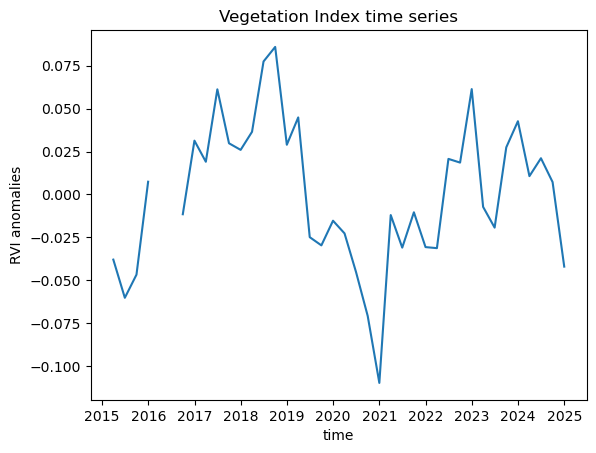

In [9]:
a = utils.preprocess_data(aoi, start, end, deseason=True)
utils.timeseries_plot(a, "RVI anomalies")

This is a trial of creating a hard classification of forest/nonforest based off of the modified Radar Forest Degredation Index value. The time series is more noisy and less easy to interpret than the 'soft' classification above.

<Axes: title={'center': 'Forest Cover in AOI'}, xlabel='time', ylabel='N Pixels Classified as Forest'>

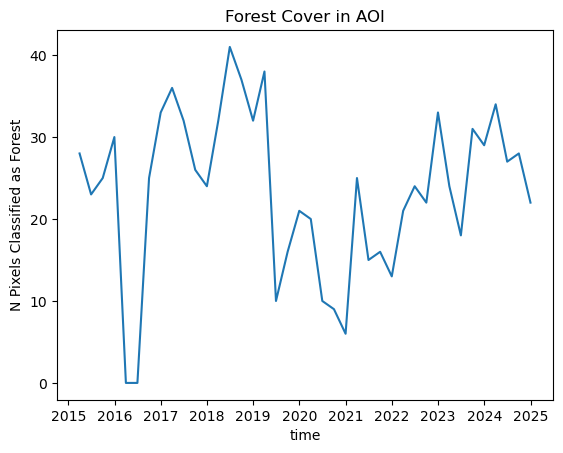

In [5]:
a = utils.preprocess_data(aoi, start, end, index_name = "mRFDI")
utils.forest_cover_plot(a, 0.5, RFDI=True)

Even at a yearly composite, hard classification of forest change has a lot of artifacts and is difficult to interpret. We do see forest loss in 2019 in this time series

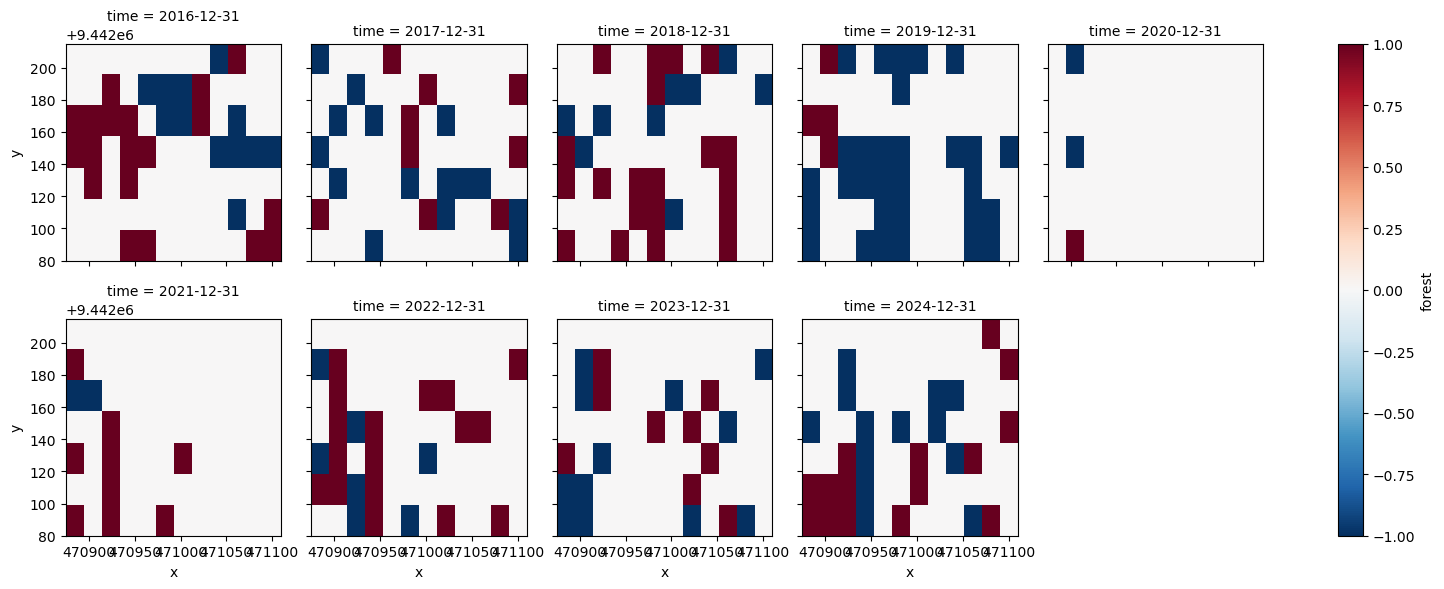

In [15]:
a = utils.preprocess_data(aoi, start, end, index_name = "mRFDI", interval="1y")
a["forest"] = a < 0.5
a.forest.astype(int).diff("time", label = "upper").plot.imshow(col="time", col_wrap=5)

Another potential method for detecting deforestation is differencing each image from the previous in the time series. However, this time series is extremely noisy and difficult to interpret

<Axes: title={'center': 'Vegetation Index time series'}, xlabel='time', ylabel='RVI Image Difference'>

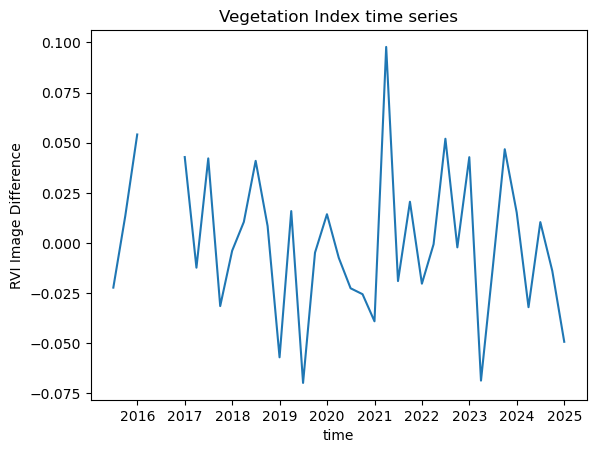

In [8]:
a = utils.preprocess_data(aoi, start, end, deseason=True)
b = utils.img_change(a)
utils.timeseries_plot(b, "RVI Image Difference")

Let's examine a 2019, when the forest area was deforested. We can see decreasing RVI values after the first quarter

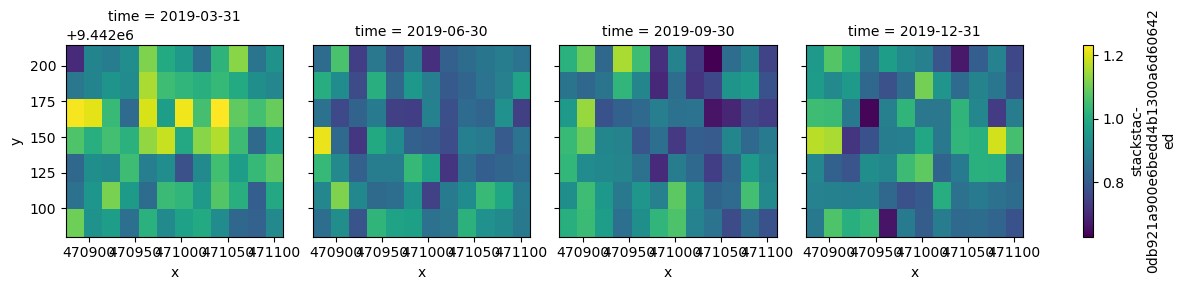

In [4]:
a = utils.preprocess_data(aoi, start, end)
utils.plot_year(a, "2019")

This function fits a linear regression to each year, outputting the linear coeficcient and residuals. Ideally this would be able to be done using a rolling function rather than for each year. Note in the 2019 and 2020 linear coefficient graphs, we see negative coeficcients in the cental area of the image, where deforestation occured.

array([<Axes: title={'center': '2024 Linear Coefficient'}, xlabel='x', ylabel='y'>,
       <Axes: title={'center': '2024 Residuals'}, xlabel='x', ylabel='y'>],
      dtype=object)

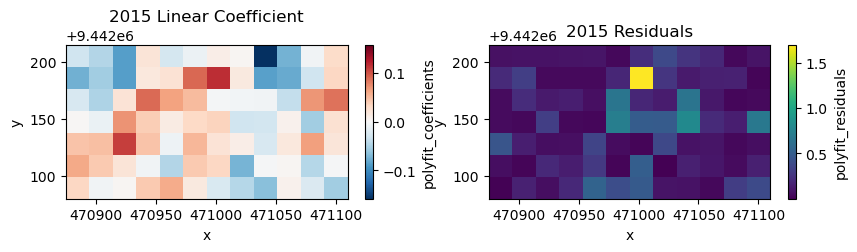

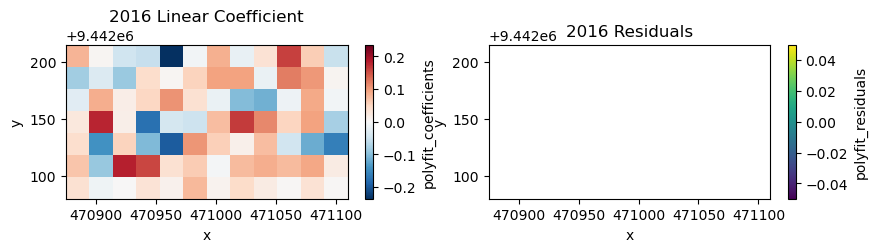

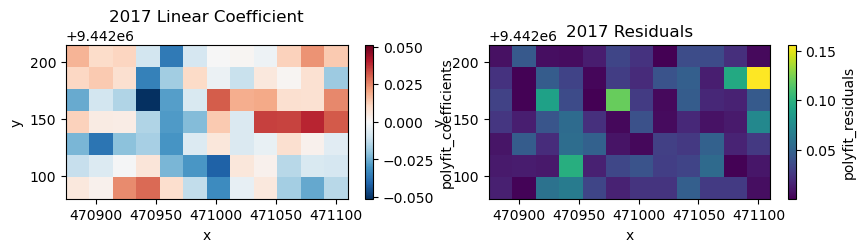

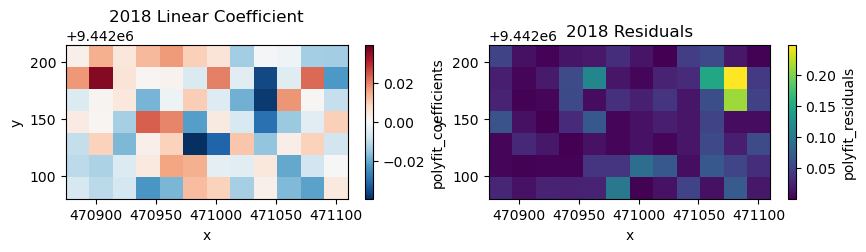

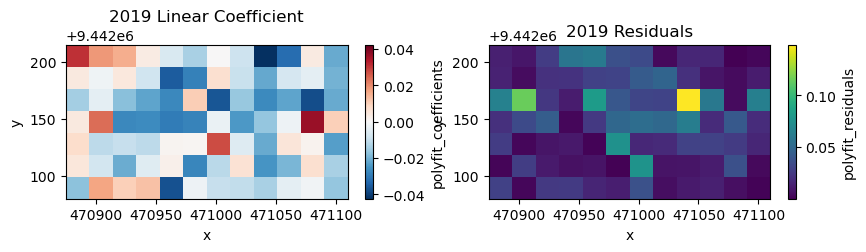

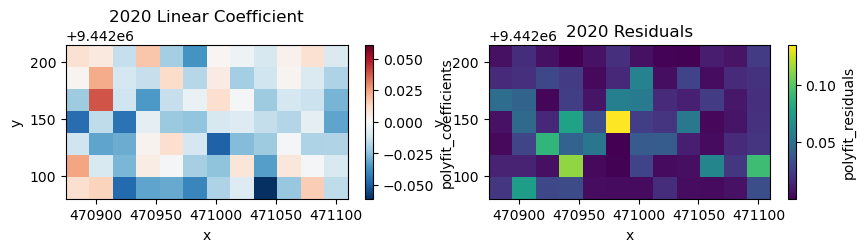

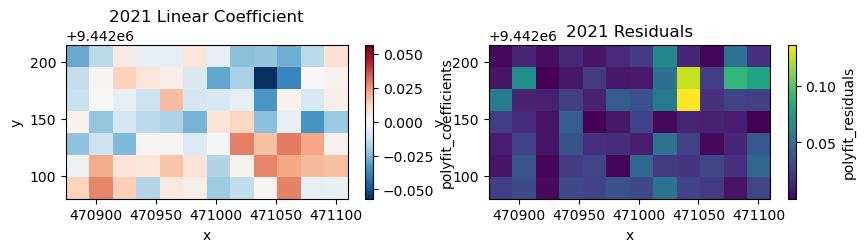

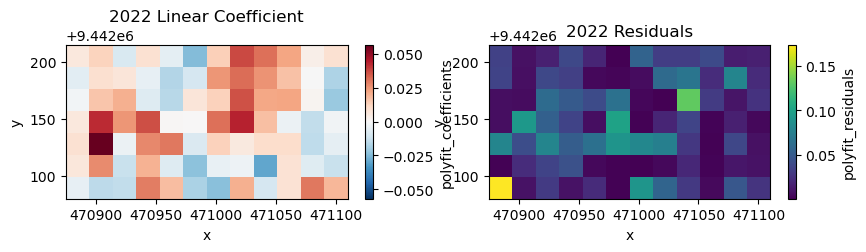

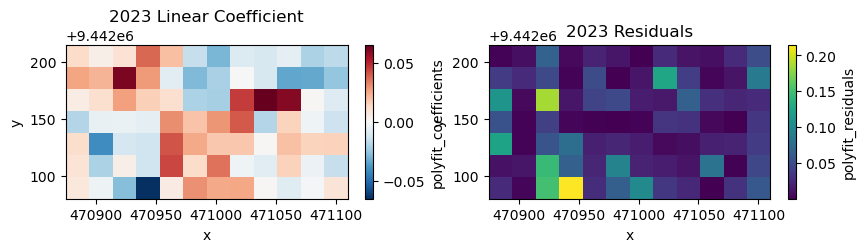

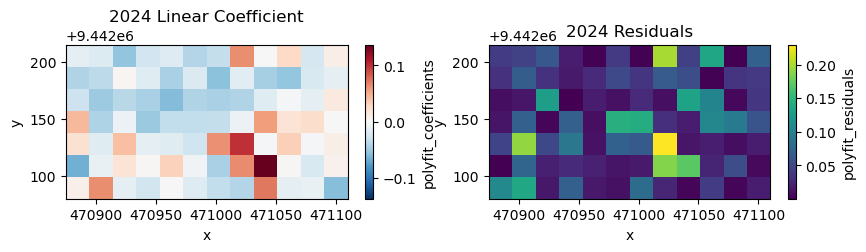

In [3]:
a = utils.preprocess_data(aoi, start, end)
utils.linear_reg_10yr(a)

### Discussion

This project produced some interesting results, however, it is still not at the level where I can difinitively say which pixels have been deforested.

The results show that creating a hard classification of forest/nonforest based off of radar vegetation index values is not suficcient, and 

One major improvement could be inergrating rolling window slope analysis. If a linear regression was fit to each quarter, the slope of the local trend for each pixel could be calculated, and pixels that experienced prolonged negative slopes could be classified as being deforested.

Attempt 1: error not being able to apply polyfit to windowed construct?  However, when looking at the structure of 'construct' it says it is a dataarray, wich should have attribute `dataarray.polyfit`

In [39]:
def linear_trend(stack):
    trend = stack.polyfit(dim = "time", deg = 1)
    return trend


rolling = preprocessed.rolling(time = 4, center = True)
construct = rolling.construct("window_dim")

construct.reduce(linear_trend)

AttributeError: 'Array' object has no attribute 'polyfit'

attempt 2: using np.polyfit. Here I get a similar error. This array should still have a time dimension?

In [38]:
import numpy as np

rolling = preprocessed.rolling(time = 3, center = True)
construct = rolling.construct("window_dim")

def linear_trend(x):
    pf = np.polyfit(x.time, x, 1)
    # need to return an xr.DataArray for groupby
    return xr.DataArray(pf[0])
    
construct.reduce(linear_trend)
 

AttributeError: 'Array' object has no attribute 'time'